In [1]:
import sys
import os 
sys.path.append('../src/detectron2/projects/DensePose')

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from src.dataset.UFOP import UFOPDataset, labels

%matplotlib inline

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
ufop_dataset = UFOPDataset()

In [4]:
lbls = labels('../data/LIBRAS-UFOP/labels.txt')

In [5]:
d = dict()
cls = dict() 


for key, values in lbls.items():        
    k = key.split('_')
    person = k[0]
    cat = k[1]
    
    sign_id = int(np.unique(values['labels']))    
        
    if person not in d.keys():
        d[person] = dict()
        
    if cat not in d[person].keys():
        d[person][cat] = 0
        
    d[person][cat] += len(values['labels'])    

        
    if cat not in cls.keys():
        cls[cat] = dict()
        
    if sign_id not in cls[cat].keys():        
        cls[cat][sign_id] = 0   
        
    cls[cat][sign_id] += len(values['labels'])    
    

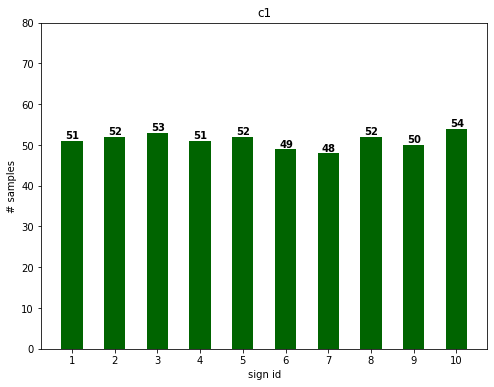

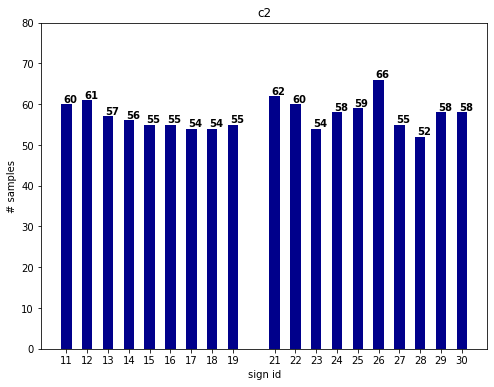

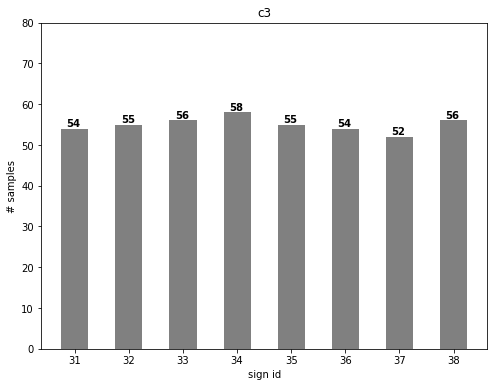

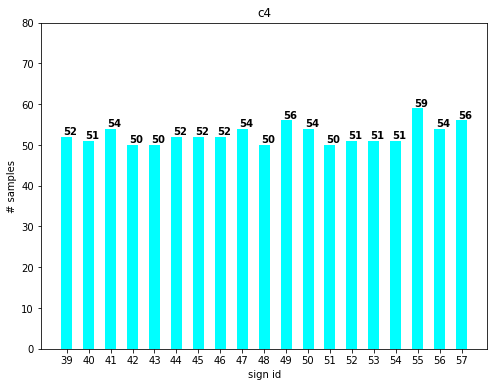

In [6]:
categories = ['c1', 'c2', 'c3', 'c4']
colors = ['darkgreen', 'darkblue', 'gray', 'cyan']

for category,color in zip(categories, colors):

    plt.figure(figsize=(8,6))

    plt.bar(x=cls[category].keys(), height=cls[category].values(), width=.5, color=color)
    plt.xticks(list(cls[category].keys()))

    for i, v in cls[category].items():
        plt.text(i-0.15, v+0.5, str(v), color='black', fontweight='bold')

    plt.ylim([0, 80])
    plt.ylabel('# samples')
    plt.xlabel('sign id')
    plt.title(category)
    plt.show()

As one may note, for Category 2, there is no class `20`.
Different from the paper's `fig.7`, here the category 2 goes up to class `30` and the whole dataset goes to `57`.
The quantity of the samples matches the paper up to class `19`. After that, the classes seems to be shifted by 1. For example, class `21` here, looks to be class `20` in the paper.

In [7]:
df = pd.DataFrame(d).T
df.sort_index(inplace=True)
df['Total'] = df.sum(axis=1)

tot = pd.DataFrame(df.sum(),).T
df = pd.concat([df, tot])

df

,c1,c2,c3,c4,Total
p1,105,221,87,206,619
p2,103,220,92,204,619
p3,105,234,90,190,619
p4,100,200,83,200,583
p5,99,214,88,199,600
0,512,1089,440,999,3040


This Dataframe corresponds to Table 3 in the papers. It looks ok!

# Training in UFOP

Here we run just an example. The complete experiments were generated by `tool/main_UFOP.py`.

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from src.dataset.UFOP import gen_cv
from src.utils.results import df_results

In [9]:
x_train, y_train = ufop_dataset.load_features(subset='set_1', 
                                              mode='train', 
                                              categ='c2', 
                                              shuffle=True, 
                                              dim=(64,48),
                                              crop_person=True, 
                                              flatten=True
                                             )

x_valid, y_valid = ufop_dataset.load_features(subset='set_1', 
                                              mode='val', 
                                              categ='c2', 
                                              shuffle=True, 
                                              dim=(64,48),
                                              crop_person=True, 
                                              flatten=True
                                             )

In [10]:
cv = gen_cv(y_train, y_valid)

In [11]:
X = np.concatenate((x_train, x_valid))
y = np.concatenate((y_train, y_valid))

print(x_train.shape, x_valid.shape, X.shape)
print(y_train.shape, y_valid.shape, y.shape)

# to save memory
del x_train, y_train, x_valid, y_valid

(707, 3072) (210, 3072) (917, 3072)
(707,) (210,) (917,)


In [12]:
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
# pipeline class is used as estimator to enable
# search over different model types

base_pipe = Pipeline([   
    ('model', SVC())
])

In [14]:
svc_space = {    
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

In [15]:
opt = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(svc_space, 16),],
    scoring='accuracy',
    cv=cv
).fit(X, y)

In [16]:
df = df_results(opt)
df

,model,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
2,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",13916.521978,2,0.000008,linear,0.728571,0.0,1
8,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",15352.958349,2,0.000007,linear,0.728571,0.0,1
12,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",146662.668338,3,0.000766,linear,0.728571,0.0,1
1,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",9132.996493,3,1.935943,poly,0.709524,0.0,4
5,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",379146.166296,3,0.001289,poly,0.709524,0.0,4
14,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",364.952459,6,0.736883,poly,0.690476,0.0,6
11,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",10236.736473,4,0.080108,poly,0.685714,0.0,7
9,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",50.000966,7,0.724255,poly,0.680952,0.0,8
15,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",193852.549496,7,7.088180,poly,0.680952,0.0,8
6,"SVC(C=13916.521978427694, degree=2, gamma=8.49...",0.001131,1,0.323239,linear,0.628571,0.0,10


In [17]:
x_test, y_test = ufop_dataset.load_features(subset='set_1', 
                                              mode='test', 
                                              categ='c2', 
                                              shuffle=True, 
                                              dim=(64,48),
                                              crop_person=True, 
                                              flatten=True
                                             )

y_test = le.transform(y_test)

In [18]:
opt.score(x_test, y_test)

0.7174887892376681

In [19]:
base_pipe = Pipeline([
    ('reduction', TruncatedSVD()),
    ('model', SVC())
])

In [20]:
svc_SVD_space = {
    'reduction': Categorical([TruncatedSVD(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),    
}

opt_SVD = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(svc_SVD_space, 16),],
    scoring='accuracy',
    cv=cv
).fit(X, y)

In [21]:
df_SVD = df_results(opt_SVD)
# df_SVD.to_csv('results_UFOP_SVM_SVD.csv')
df_SVD

,model,model__C,model__degree,model__gamma,model__kernel,reduction,reduction__n_components,mean_test_score,std_test_score,rank
13,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",7719.888876,6,0.000001,rbf,"TruncatedSVD(n_components=112, random_state=0)",112,0.728571,0.0,1
14,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",4789.718761,7,0.000001,rbf,"TruncatedSVD(n_components=112, random_state=0)",108,0.723810,0.0,2
11,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",1382.278806,4,0.000002,rbf,"TruncatedSVD(n_components=112, random_state=0)",121,0.704762,0.0,3
7,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",7304.248986,4,0.000002,rbf,"TruncatedSVD(n_components=112, random_state=0)",120,0.695238,0.0,4
4,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",10.441533,7,0.000903,linear,"TruncatedSVD(n_components=112, random_state=0)",86,0.685714,0.0,5
15,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",24753.402922,1,0.000191,linear,"TruncatedSVD(n_components=112, random_state=0)",91,0.680952,0.0,6
2,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",16702.642943,3,6.956672,poly,"TruncatedSVD(n_components=112, random_state=0)",114,0.666667,0.0,7
6,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",18.610184,4,2.159689,poly,"TruncatedSVD(n_components=112, random_state=0)",90,0.657143,0.0,8
8,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",0.392175,2,0.003591,rbf,"TruncatedSVD(n_components=112, random_state=0)",92,0.638095,0.0,9
5,"SVC(C=7719.888876063456, degree=6, gamma=1.429...",0.000374,8,0.698777,poly,"TruncatedSVD(n_components=112, random_state=0)",71,0.609524,0.0,10


In [22]:
# result on test set
opt_SVD.score(x_test, y_test)

0.7130044843049327

## Taking a look at UFOP

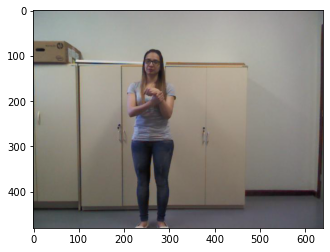

(480, 640, 3)


In [23]:
video = ufop_dataset[30]
frame = video.get_frame(40)
plt.imshow(frame[:,:,::-1])

plt.show()
print(frame.shape)

In [24]:
# Generate segmentation

In [25]:
import sys
import os
sys.path.append('../src/detectron2/projects/DensePose/')

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor


from densepose import add_densepose_config, add_hrnet_config

from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.extractor import CompoundExtractor, create_extractor

In [26]:
config_file = '../src/detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml'
model_url = 'https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl'

In [27]:
VISUALIZERS = {
        "dp_contour": DensePoseResultsContourVisualizer,
        "dp_segm": DensePoseResultsFineSegmentationVisualizer,
        "dp_u": DensePoseResultsUVisualizer,
        "dp_v": DensePoseResultsVVisualizer,
        "bbox": ScoredBoundingBoxVisualizer,
    }

def create_context(vis_specs):        
        visualizers = []
        extractors = []
        for vis_spec in vis_specs:
            vis = VISUALIZERS[vis_spec]()
            visualizers.append(vis)
            extractor = create_extractor(vis)
            extractors.append(extractor)
        visualizer = CompoundVisualizer(visualizers)
        extractor = CompoundExtractor(extractors)
        context = {
            "extractor": extractor,
            "visualizer": visualizer,
#             "out_fname": args.output,
#             "entry_idx": 0,
        }
        return context

In [28]:
# Inference with a keypoint detection model
cfg = get_cfg()

add_densepose_config(cfg)
add_hrnet_config(cfg)    
cfg.merge_from_file(config_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_url

predictor = DefaultPredictor(cfg)
outputs = predictor(frame)

Config '../src/detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
/home/wesley.passos/repos/libras/src/detectron2/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


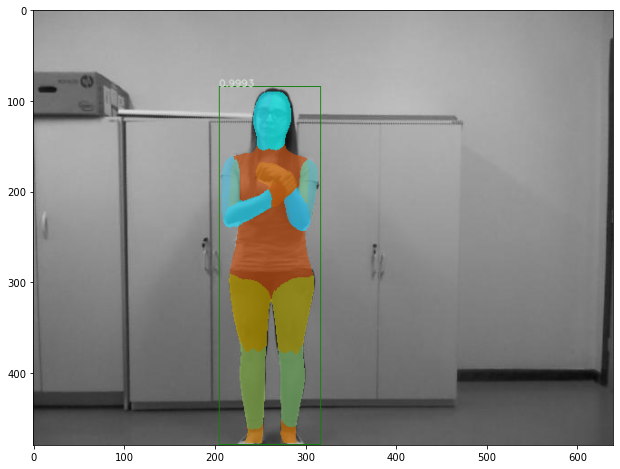

In [29]:
context = create_context(('bbox', 'dp_segm',))

visualizer = context["visualizer"]
extractor = context["extractor"]

image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
image = np.tile(image[:, :, np.newaxis], [1, 1, 3])
data = extractor(outputs['instances'])

plt.figure(figsize=(12,8))

image_vis = visualizer.visualize(image, data)
plt.imshow(image_vis)
plt.show()

In [30]:
# The movements were performed more than once in each video
# the method `get_movement_frames` returns a list of tuples 
# containing the initial and end frame of the gestures in the video
ufop_dataset[0].get_movement_frames()

[(29, 54),
 (92, 118),
 (156, 179),
 (214, 242),
 (291, 320),
 (356, 388),
 (429, 462),
 (496, 529),
 (568, 595),
 (636, 663),
 (706, 734),
 (773, 799),
 (838, 867),
 (906, 937),
 (974, 1007)]

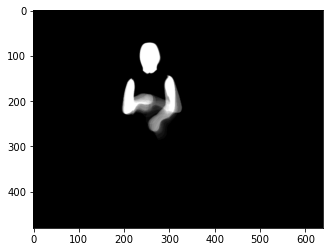

In [31]:
# read the gei generated (png format)
gei_ = cv2.imread("../data/LIBRAS-UFOP/gei/p1_c2_s12/gei_029_054.png",  cv2.IMREAD_GRAYSCALE)/255

plt.figure()
plt.imshow(gei_, cmap='gray')
plt.show()

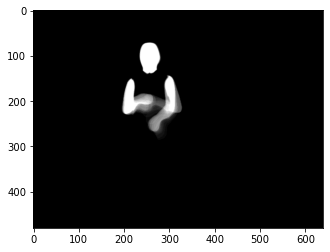

(480, 640)


In [32]:
# read the gei generated (pickle format)
import pickle
with open("../data/LIBRAS-UFOP/gei/p1_c2_s12/gei_029_054.pkl", 'rb') as f:
    x = pickle.load(f)

plt.figure()
plt.imshow(x, cmap='gray')
plt.show()
print(x.shape)